In [39]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
import math


## Data Loading

In [40]:
# 数据路径
train_path = '/Users/chenjiayi/Desktop/Deep Learning/Assignment 3/archive/Google_Stock_Price_Train.csv'
test_path = '/Users/chenjiayi/Desktop/Deep Learning/Assignment 3/archive/Google_Stock_Price_Test.csv'
# 数据加载
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [41]:
# 查看数据结构
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


## Data Pre-processing

In [43]:
# 提取所需的特征列
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# 数据清理：去除逗号并转换为浮点型
def clean_data(df, columns):
    for col in columns:
        df[col] = df[col].replace({',': ''}, regex=True).astype(float)
    return df

# 清理训练集和测试集
train_data = clean_data(train_data, features)
test_data = clean_data(test_data, features)

# 提取特征列并进行归一化
training_set = train_data[features].values
testing_set = test_data[features].values
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [44]:
# 定义滑窗大小
N = 30  # 过去 N 天的数据
M = 1   # 预测未来 M 天的数据

# 创建滑窗数据
def create_dataset(data, time_steps, future_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps:i+time_steps+future_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(training_set_scaled, N, M)

# 拆分验证集
validation_split = 0.2
val_size = int(len(X_train) * validation_split)
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

# 测试集数据处理
total_data = np.concatenate((training_set, testing_set), axis=0)
inputs = total_data[len(total_data) - len(testing_set) - N:]
inputs_scaled = scaler.transform(inputs)

X_test, y_test = create_dataset(inputs_scaled, N, M)

/var/folders/0g/zz9klycd67s_yxd2m73_4pnh0000gn/T/ipykernel_28274/1475848756.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train.ravel(), label='Training Data', shade=True)
/var/folders/0g/zz9klycd67s_yxd2m73_4pnh0000gn/T/ipykernel_28274/1475848756.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_val.ravel(), label='Validation Data', shade=True)


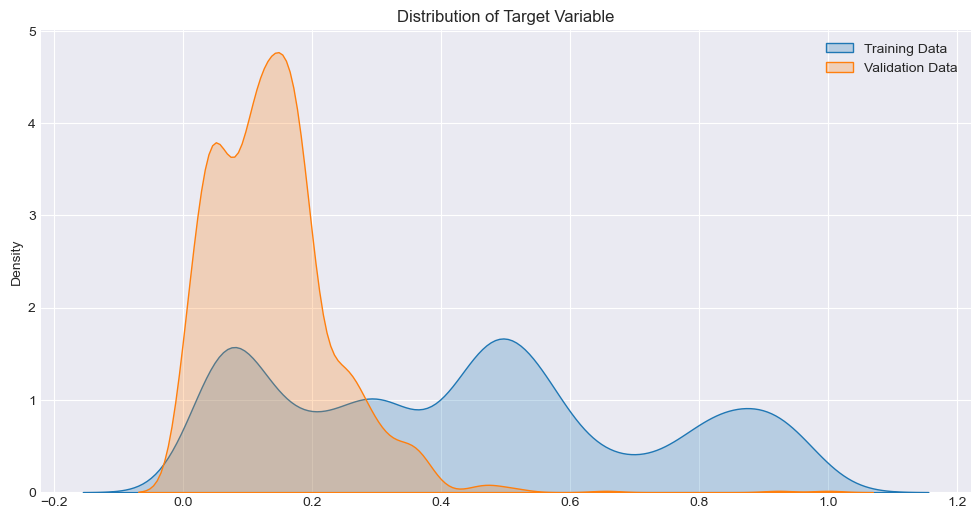

In [45]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train.ravel(), label='Training Data', shade=True)
sns.kdeplot(y_val.ravel(), label='Validation Data', shade=True)
plt.legend()
plt.title('Distribution of Target Variable')
plt.show()

/var/folders/0g/zz9klycd67s_yxd2m73_4pnh0000gn/T/ipykernel_28274/673239743.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


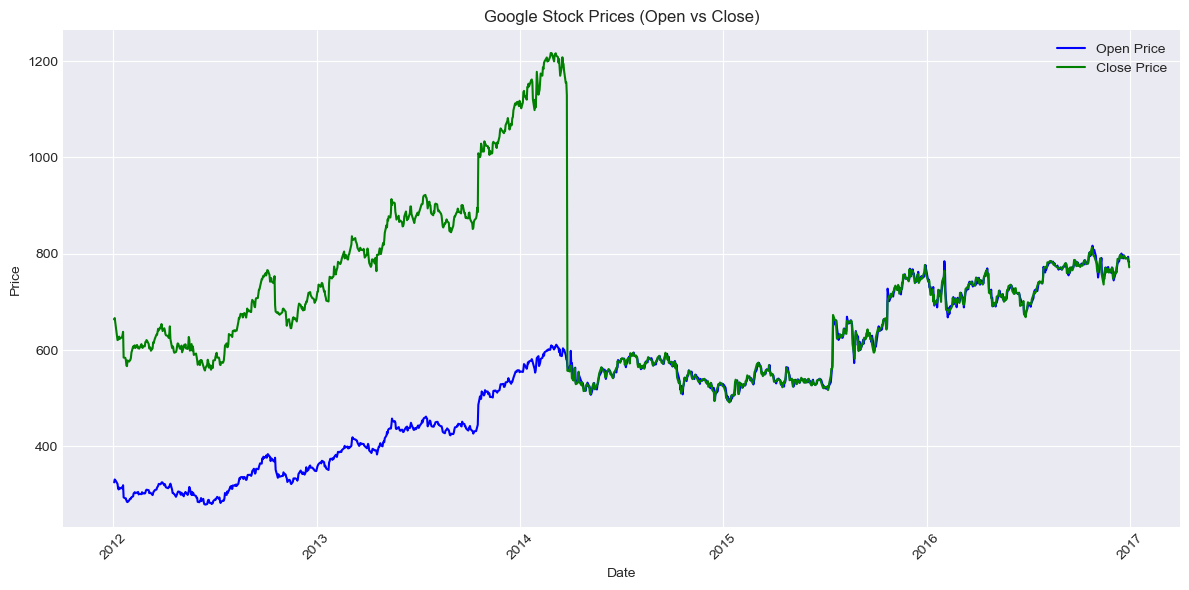

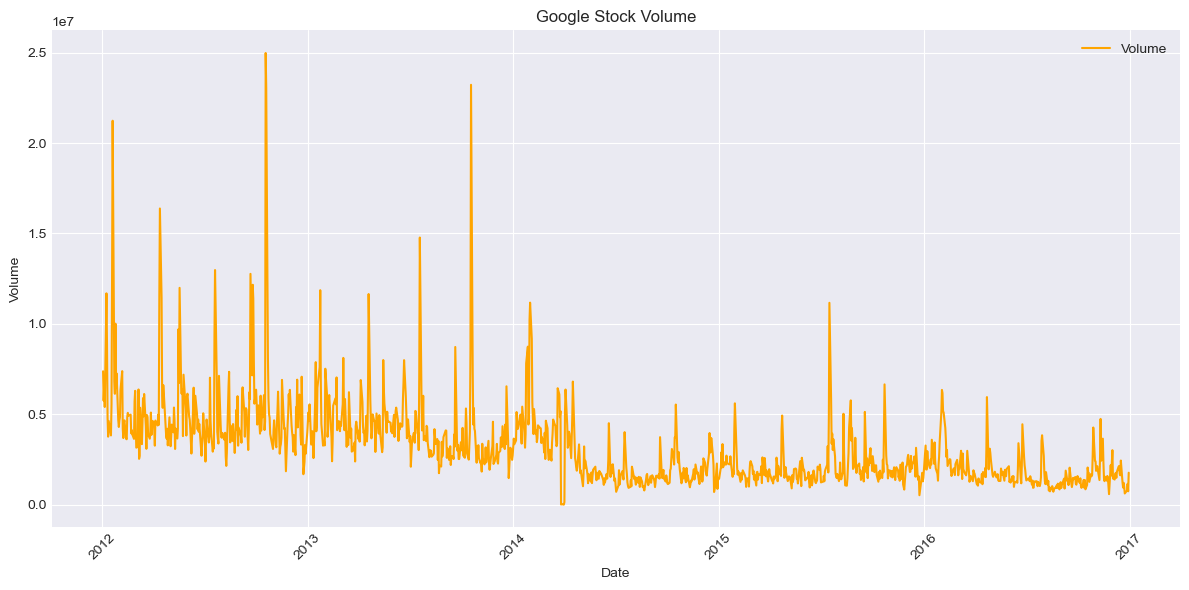

In [46]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 可视化开盘价和收盘价
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Open'], label='Open Price', color='blue')
plt.plot(train_data['Date'], train_data['Close'], label='Close Price', color='green')
plt.title('Google Stock Prices (Open vs Close)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # 日期标签旋转以便更清晰
plt.tight_layout()
plt.show()

# 可视化交易量
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Volume'], label='Volume', color='orange')
plt.title('Google Stock Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Baseline Model

### Simple RNN Model

In [47]:
# 构建基线 RNN 模型
rnn_model = Sequential([
    SimpleRNN(units=50, return_sequences=False, input_shape=(N, len(features))),
    Dense(units=M * len(features))  # 输出未来 M 天的所有特征
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 模型训练
history = rnn_model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=50, batch_size=32, validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

# 模型预测
train_predictions = rnn_model.predict(X_train)
train_predictions = train_predictions.reshape(train_predictions.shape[0], M, len(features))
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

val_predictions = rnn_model.predict(X_val)
val_predictions = val_predictions.reshape(val_predictions.shape[0], M, len(features))
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

predictions = rnn_model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0], M, len(features))
predictions = scaler.inverse_transform(predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

# 反归一化真实值
y_train_original = scaler.inverse_transform(y_train.reshape(-1, len(features))).reshape(-1, M, len(features))
y_val_original = scaler.inverse_transform(y_val.reshape(-1, len(features))).reshape(-1, M, len(features))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, len(features))).reshape(-1, M, len(features))

# 模型评估函数
def evaluate_model(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return rmse, mae

# 准确率计算函数
def calculate_accuracy(y_true, y_pred, threshold=0.05):
    """计算准确率，预测与真实值的相对误差小于 threshold 视为预测正确"""
    epsilon = 1e-10  # 防止分母为零
    relative_errors = np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))
    correct_predictions = relative_errors < threshold
    accuracy = np.mean(correct_predictions) * 100
    return accuracy

# 评估训练集、验证集和测试集的性能
train_rmse, train_mae = evaluate_model(y_train_original, train_predictions)
train_accuracy = calculate_accuracy(y_train_original, train_predictions)

val_rmse, val_mae = evaluate_model(y_val_original, val_predictions)
val_accuracy = calculate_accuracy(y_val_original, val_predictions)

test_rmse, test_mae = evaluate_model(y_test_actual, predictions)
test_accuracy = calculate_accuracy(y_test_actual, predictions)

# 存储 RNN 结果
rnn_results = {
    "Model": "Simple RNN",
    "Train RMSE": train_rmse,
    "Train MAE": train_mae,
    "Train Accuracy": train_accuracy,
    "Val RMSE": val_rmse,
    "Val MAE": val_mae,
    "Val Accuracy": val_accuracy,
    "Test RMSE": test_rmse,
    "Test MAE": test_mae,
    "Test Accuracy": test_accuracy
}

# 打印 RNN 结果
print("\nRNN Model Results:")
for key, value in rnn_results.items():
    print(f"{key}: {value}")



Epoch 1/50


/Users/chenjiayi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.2795 - val_loss: 0.0890
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0141 - val_loss: 0.0357
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - val_loss: 0.0307
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - val_loss: 0.0262
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031 - val_loss: 0.0194
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - val_loss: 0.0124
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025 - val_loss: 0.0137
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_l

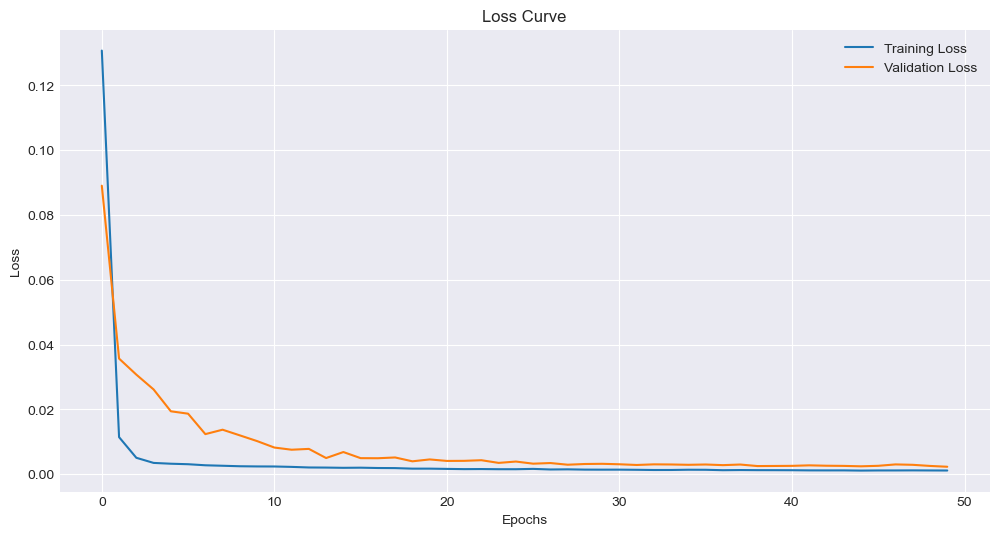

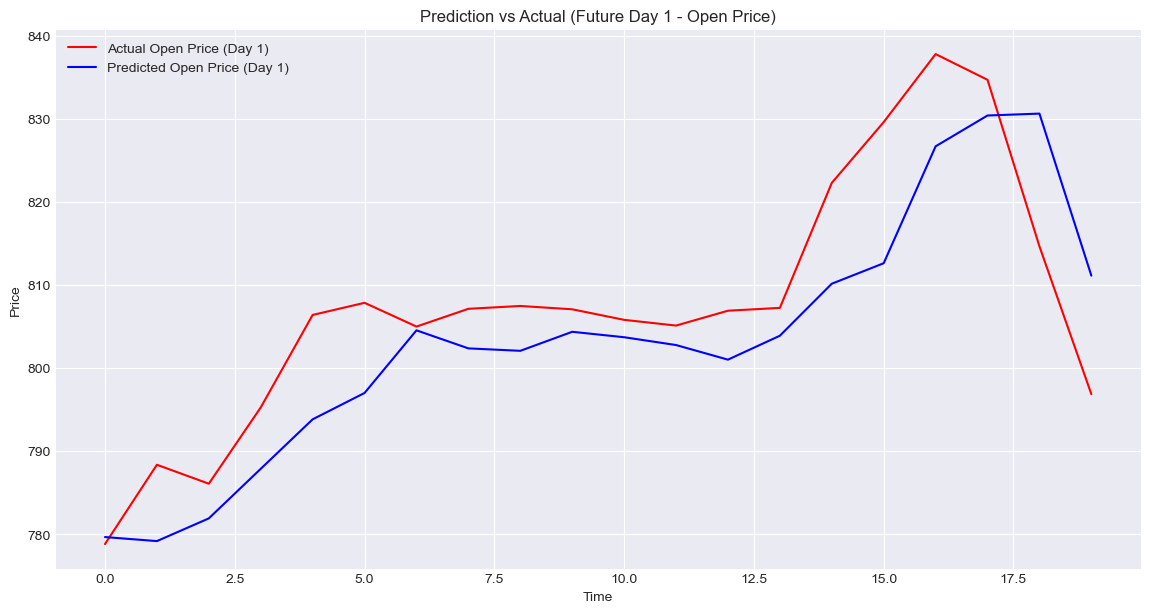

In [48]:
# 可视化损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 可视化预测对比（未来第 1 天的开盘价为例）
feature_idx = 0  # 选择开盘价
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:, 0, feature_idx], color='red', label='Actual Open Price (Day 1)')
plt.plot(predictions[:, 0, feature_idx], color='blue', label='Predicted Open Price (Day 1)')
plt.title('Prediction vs Actual (Future Day 1 - Open Price)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### RGU Model

In [49]:
# 构建 GRU 模型
gru_model = Sequential([
    GRU(units=50, return_sequences=False, input_shape=(N, len(features))),
    Dense(units=M * len(features))  # 输出未来 M 天的所有特征
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 模型训练
history = gru_model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=50, batch_size=32, validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

# 模型预测
train_predictions = gru_model.predict(X_train)
train_predictions = train_predictions.reshape(train_predictions.shape[0], M, len(features))
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

val_predictions = gru_model.predict(X_val)
val_predictions = val_predictions.reshape(val_predictions.shape[0], M, len(features))
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

predictions = gru_model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0], M, len(features))
predictions = scaler.inverse_transform(predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

# 反归一化真实值
y_train_original = scaler.inverse_transform(y_train.reshape(-1, len(features))).reshape(-1, M, len(features))
y_val_original = scaler.inverse_transform(y_val.reshape(-1, len(features))).reshape(-1, M, len(features))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, len(features))).reshape(-1, M, len(features))

# 模型评估函数
def evaluate_model(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return rmse, mae

# 准确率计算函数
def calculate_accuracy(y_true, y_pred, threshold=0.05):
    """计算准确率，预测与真实值的相对误差小于 threshold 视为预测正确"""
    epsilon = 1e-10  # 防止分母为零
    relative_errors = np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))
    correct_predictions = relative_errors < threshold
    accuracy = np.mean(correct_predictions) * 100
    return accuracy

# 评估训练集、验证集和测试集的性能
train_rmse, train_mae = evaluate_model(y_train_original, train_predictions)
train_accuracy = calculate_accuracy(y_train_original, train_predictions)

val_rmse, val_mae = evaluate_model(y_val_original, val_predictions)
val_accuracy = calculate_accuracy(y_val_original, val_predictions)

test_rmse, test_mae = evaluate_model(y_test_actual, predictions)
test_accuracy = calculate_accuracy(y_test_actual, predictions)

# 存储 GRU 结果
gru_results = {
    "Model": "GRU Model",
    "Train RMSE": train_rmse,
    "Train MAE": train_mae,
    "Train Accuracy": train_accuracy,
    "Val RMSE": val_rmse,
    "Val MAE": val_mae,
    "Val Accuracy": val_accuracy,
    "Test RMSE": test_rmse,
    "Test MAE": test_mae,
    "Test Accuracy": test_accuracy
}

# 打印 GRU 结果
print("\nGRU Model Results:")
for key, value in rnn_results.items():
    print(f"{key}: {value}")




/Users/chenjiayi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1958 - val_loss: 0.0298
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0137 - val_loss: 0.0182
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0057 - val_loss: 0.0134
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0033 - val_loss: 0.0111
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - val_loss: 0.0084
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

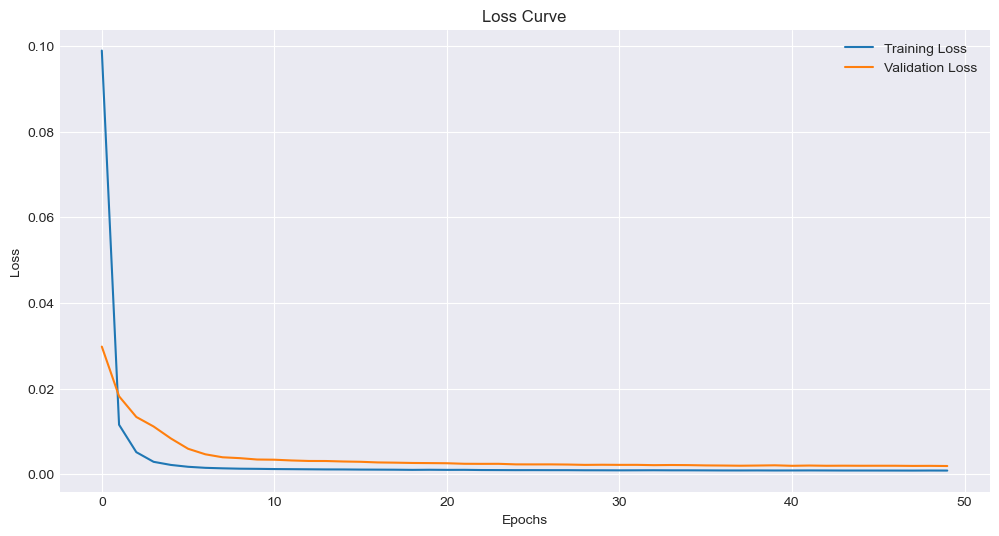

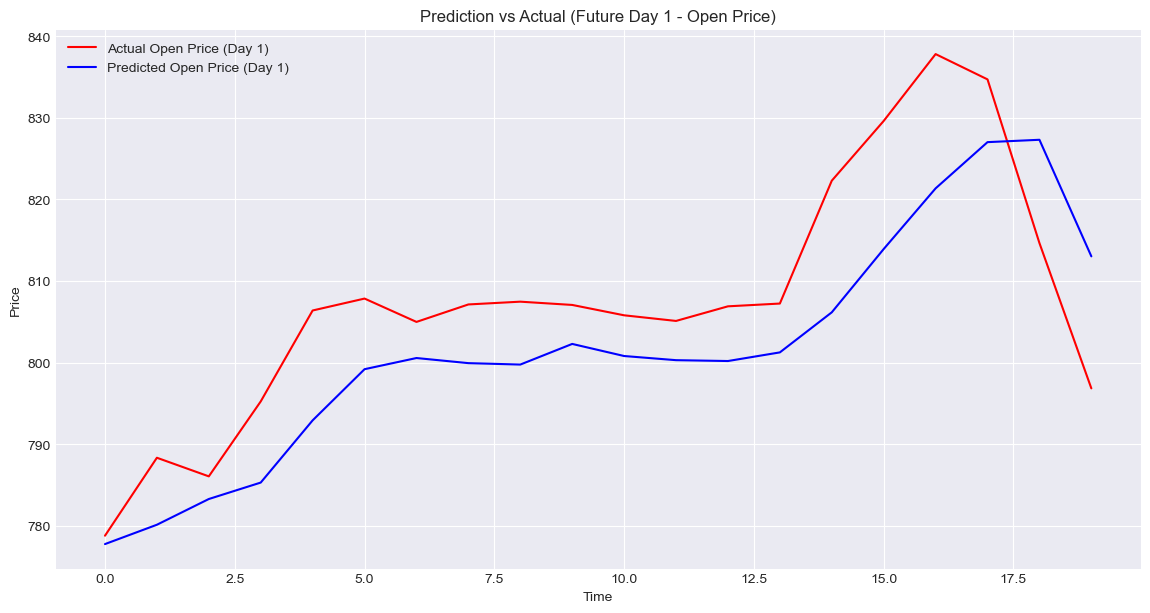

In [50]:
# 可视化损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 可视化预测对比（未来第 1 天的开盘价为例）
feature_idx = 0  # 选择开盘价
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:, 0, feature_idx], color='red', label='Actual Open Price (Day 1)')
plt.plot(predictions[:, 0, feature_idx], color='blue', label='Predicted Open Price (Day 1)')
plt.title('Prediction vs Actual (Future Day 1 - Open Price)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### LSTM Model

In [51]:
# 模型设计
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(N, len(features))),
    LSTM(units=50, return_sequences=False),
    Dense(units=M * len(features))  # 输出未来 M 天的所有特征
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 模型训练
history = lstm_model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=50, batch_size=32, validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

# 模型预测
train_predictions = lstm_model.predict(X_train)
train_predictions = train_predictions.reshape(train_predictions.shape[0], M, len(features))
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

val_predictions = lstm_model.predict(X_val)
val_predictions = val_predictions.reshape(val_predictions.shape[0], M, len(features))
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

# 对 y_train 和 y_val 进行反归一化
y_train_original = scaler.inverse_transform(y_train.reshape(-1, len(features))).reshape(-1, M, len(features))
y_val_original = scaler.inverse_transform(y_val.reshape(-1, len(features))).reshape(-1, M, len(features))

# 评估模型的 RMSE 和 MAE
def evaluate_model(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return rmse, mae

# 计算准确率
def calculate_accuracy(y_true, y_pred, threshold=0.05):
    """计算准确率，预测与真实值的相对误差小于 threshold 视为预测正确"""
    epsilon = 1e-10  # 防止分母为零
    relative_errors = np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))
    correct_predictions = relative_errors < threshold
    accuracy = np.mean(correct_predictions) * 100
    return accuracy

# 评估训练集和验证集的性能
train_rmse, train_mae = evaluate_model(y_train_original, train_predictions)
train_accuracy = calculate_accuracy(y_train_original, train_predictions)

val_rmse, val_mae = evaluate_model(y_val_original, val_predictions)
val_accuracy = calculate_accuracy(y_val_original, val_predictions)

# 测试集预测
predictions = lstm_model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0], M, len(features))
predictions = scaler.inverse_transform(predictions.reshape(-1, len(features))).reshape(-1, M, len(features))

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, len(features))).reshape(-1, M, len(features))
test_rmse, test_mae = evaluate_model(y_test_actual, predictions)
test_accuracy = calculate_accuracy(y_test_actual, predictions)

# 存储 LSTM 结果
lstm_results = {
    "Model": "LSTM Model",
    "Train RMSE": train_rmse,
    "Train MAE": train_mae,
    "Train Accuracy": train_accuracy,
    "Val RMSE": val_rmse,
    "Val MAE": val_mae,
    "Val Accuracy": val_accuracy,
    "Test RMSE": test_rmse,
    "Test MAE": test_mae,
    "Test Accuracy": test_accuracy
}

# 打印 LSTM 结果
print("\nLSTM Model Results:")
for key, value in lstm_results.items():
    print(f"{key}: {value}")

Epoch 1/50


/Users/chenjiayi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.1212 - val_loss: 0.0094
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0016 - val_l

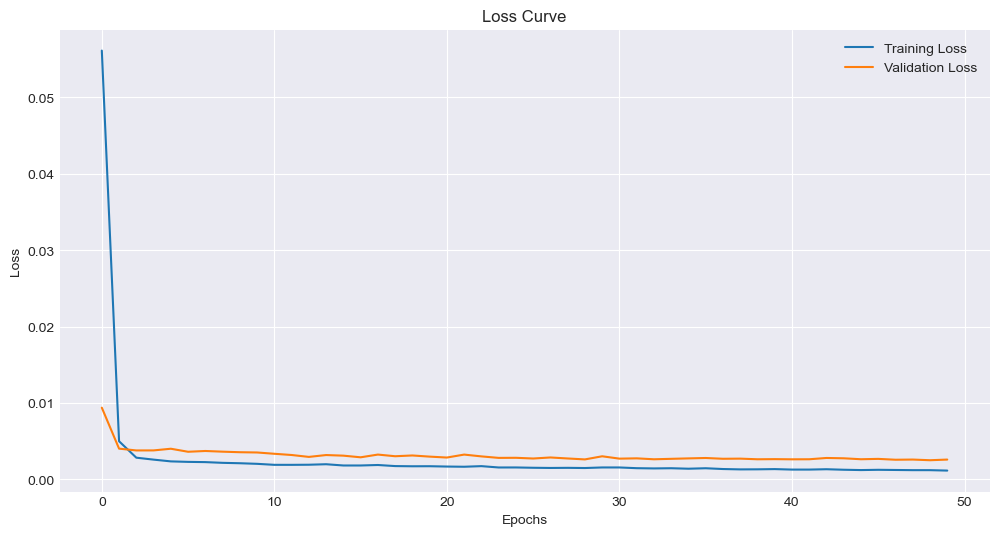

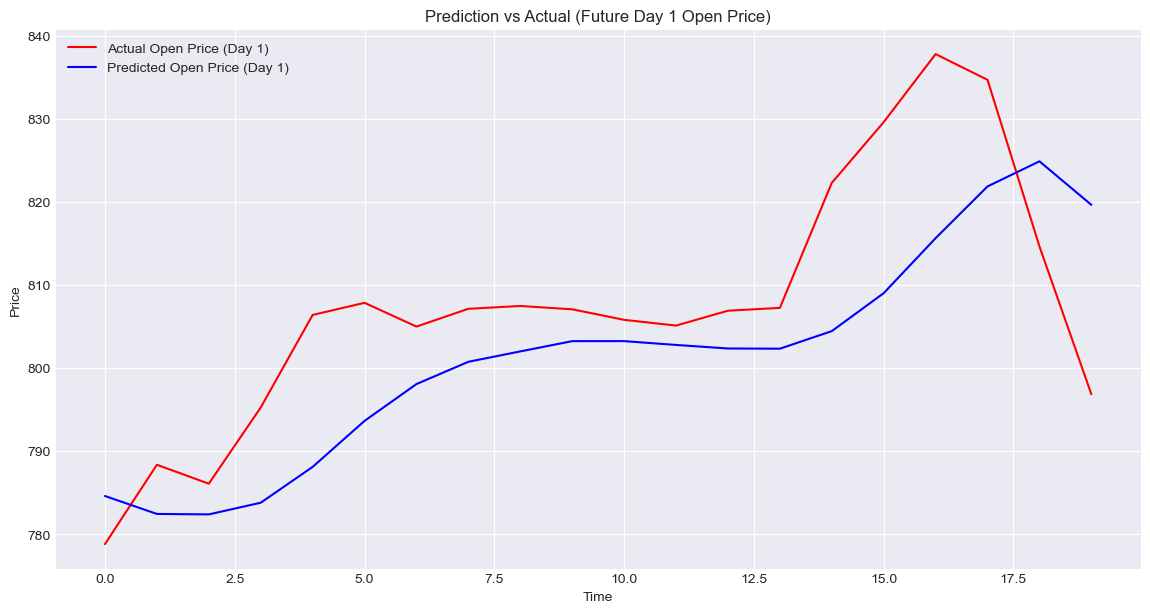

In [52]:
# 可视化损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 可视化预测对比（未来第 1 天的开盘价为例）
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:, 0, 0], color='red', label='Actual Open Price (Day 1)')
plt.plot(predictions[:, 0, 0], color='blue', label='Predicted Open Price (Day 1)')
plt.title('Prediction vs Actual (Future Day 1 Open Price)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Results Display

In [54]:
# 将结果存储到一个 DataFrame 中
results_df = pd.DataFrame([rnn_results, gru_results, lstm_results])

# 打印结果
print("Model Comparison:")
print(results_df)


Model Comparison:
        Model     Train RMSE      Train MAE  Train Accuracy      Val RMSE  \
0  Simple RNN  543776.162988  158891.932869       79.226857  1.025124e+06   
1   GRU Model  525861.597267  138621.149684       81.810783  1.039485e+06   
2  LSTM Model  573558.292039  148631.139877       79.633774  1.189587e+06   

         Val MAE  Val Accuracy      Test RMSE       Test MAE  Test Accuracy  
0  262000.883011     65.306122  263275.299273   87757.356040           80.0  
1  265263.376563     80.571429  240763.658960   94088.130057           80.0  
2  289865.526544     74.285714  269932.853891  104487.723951           82.0  


## Model Improvement

Epoch 1/50


/Users/chenjiayi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.1214 - val_loss: 0.0151
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0157 - val_loss: 0.0111
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0088 - val_loss: 0.0064
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0061 - val_l

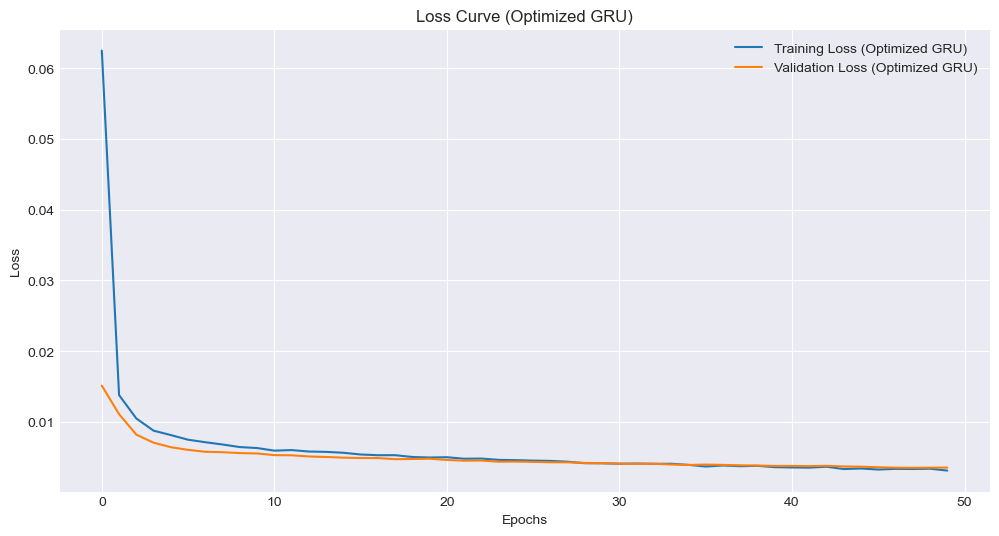

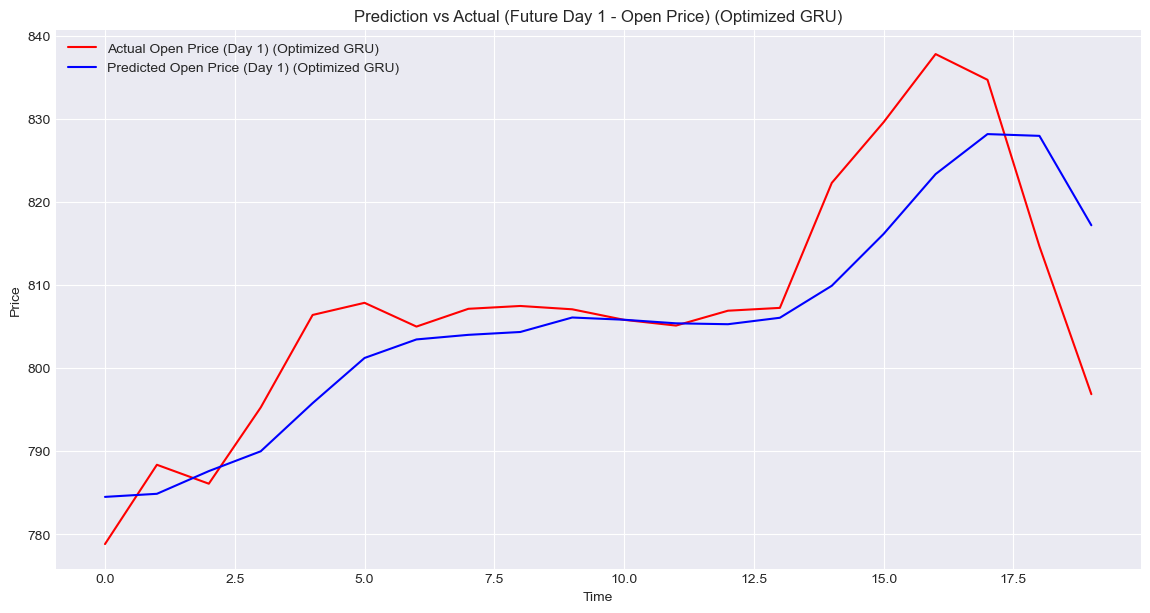

In [69]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# 进一步优化正则化后的 GRU 模型
optimized_gru_model = Sequential([
    # 第一层 GRU：减少 L2 正则化强度，保留较小的 Dropout
    GRU(units=64, return_sequences=True, input_shape=(N, len(features)), kernel_regularizer=l2(0.0001)),
    Dropout(0.05),
    
    # 第二层 GRU：保持轻微的正则化以防止过拟合
    GRU(units=32, return_sequences=False, kernel_regularizer=l2(0.0001)),
    Dropout(0.05),
    
    # 输出层
    Dense(units=M * len(features))  # 输出未来 M 天的所有特征
])

# 编译模型
optimized_gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 训练模型
history_optimized_gru = optimized_gru_model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1))
)

# 模型预测
train_predictions_optimized_gru = optimized_gru_model.predict(X_train)
val_predictions_optimized_gru = optimized_gru_model.predict(X_val)
test_predictions_optimized_gru = optimized_gru_model.predict(X_test)

# 反归一化预测值和真实值
train_predictions_optimized_gru = scaler.inverse_transform(train_predictions_optimized_gru.reshape(-1, len(features))).reshape(-1, M, len(features))
val_predictions_optimized_gru = scaler.inverse_transform(val_predictions_optimized_gru.reshape(-1, len(features))).reshape(-1, M, len(features))
test_predictions_optimized_gru = scaler.inverse_transform(test_predictions_optimized_gru.reshape(-1, len(features))).reshape(-1, M, len(features))

y_train_original_optimized_gru = scaler.inverse_transform(y_train.reshape(-1, len(features))).reshape(-1, M, len(features))
y_val_original_optimized_gru = scaler.inverse_transform(y_val.reshape(-1, len(features))).reshape(-1, M, len(features))
y_test_actual_optimized_gru = scaler.inverse_transform(y_test.reshape(-1, len(features))).reshape(-1, M, len(features))

# 评估性能
train_rmse_optimized_gru, train_mae_optimized_gru = evaluate_model(y_train_original_optimized_gru, train_predictions_optimized_gru)
val_rmse_optimized_gru, val_mae_optimized_gru = evaluate_model(y_val_original_optimized_gru, val_predictions_optimized_gru)
test_rmse_optimized_gru, test_mae_optimized_gru = evaluate_model(y_test_actual_optimized_gru, test_predictions_optimized_gru)

train_accuracy_optimized_gru = calculate_accuracy(y_train_original_optimized_gru, train_predictions_optimized_gru)
val_accuracy_optimized_gru = calculate_accuracy(y_val_original_optimized_gru, val_predictions_optimized_gru)
test_accuracy_optimized_gru = calculate_accuracy(y_test_actual_optimized_gru, test_predictions_optimized_gru)

# 打印评估结果
print(f"Train RMSE (Optimized GRU): {train_rmse_optimized_gru:.2f}, Train MAE (Optimized GRU): {train_mae_optimized_gru:.2f}, Train Accuracy (Optimized GRU): {train_accuracy_optimized_gru:.2f}%")
print(f"Validation RMSE (Optimized GRU): {val_rmse_optimized_gru:.2f}, Validation MAE (Optimized GRU): {val_mae_optimized_gru:.2f}, Validation Accuracy (Optimized GRU): {val_accuracy_optimized_gru:.2f}%")
print(f"Test RMSE (Optimized GRU): {test_rmse_optimized_gru:.2f}, Test MAE (Optimized GRU): {test_mae_optimized_gru:.2f}, Test Accuracy (Optimized GRU): {test_accuracy_optimized_gru:.2f}%")

# 可视化损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history_optimized_gru.history['loss'], label='Training Loss (Optimized GRU)')
plt.plot(history_optimized_gru.history['val_loss'], label='Validation Loss (Optimized GRU)')
plt.title('Loss Curve (Optimized GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 可视化预测对比（未来第 1 天的开盘价为例）
feature_idx = 0  # 选择开盘价
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual_optimized_gru[:, 0, feature_idx], color='red', label='Actual Open Price (Day 1) (Optimized GRU)')
plt.plot(test_predictions_optimized_gru[:, 0, feature_idx], color='blue', label='Predicted Open Price (Day 1) (Optimized GRU)')
plt.title('Prediction vs Actual (Future Day 1 - Open Price) (Optimized GRU)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
